In [40]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
data_dir = "../"

# Reaction Time on SLO Breach

This data visualizes the reaction time of the system in case of an SLO-Breach. To collect this data three different methods were used to simulate a breach. For deployments to AWS Lambda, the breach was simulated by changing the limit of the latency slo to 0. To simulate the breach on OpenFaaS resources the benchmark application ran the linux tool "stress" for two cpu cores, which increased the cpu utilisation above the limit of the selected ensemble. On K8S resources a similar approach was applied. The benchmark tool started up a pod where the linux tool "stress" has been executed to increase the current cpu utilisation. Following setups have been tested:
- Lambda: 
      - function 1 on resource 14 with 1 and 4 concurrent deployments
      - function 1, 2, 3 on resources 14, 15 with 1 and 4 concurrent deployments
- K8S:
      - service 1 on resource 7 with 1 and 4 concurrent deployments
      - service 1 on resource 7, 8, 9 with 1 and 4 concurrent deployments
- OpenFaaS:
      - function 1 on resource 2 with 1 and 4 concurrent deployments
      - function 1 ond resource 1, 2, 3 with 1 and 4 concurrent deployments

The original data can be found in [reaction_time](../reaction_time)

In [41]:
ru_dir = os.path.join(data_dir, "reaction_time")

In [42]:
df_timestamps = pd.DataFrame()
df_alert = pd.DataFrame()

for root, dirs, files in os.walk(ru_dir):
       for subdir in dirs:
              curr_ru_dir = os.path.join(root, subdir)               
              start_timestamp = 0
              for file_path in glob.glob(curr_ru_dir + "/*.csv"):
                     df = pd.read_csv(file_path)
                     df["type"] = subdir + file_path.split(curr_ru_dir)[1].split('_')[0]
                     concurrent_deployments = file_path.split(curr_ru_dir)[1].split('_')[1].split('.')[0]
                     
                     df['concurrent_deployments'] = int(concurrent_deployments)
              
                     if file_path.endswith('_alert.csv'):
                            df["timestamp"] = df["timestamp"] - start_timestamp
                            if 'deployment' not in df:
                                   df['deployment'] = 1
                            df = df.drop(df[df["timestamp"] < 0].index)
                            df_alert = pd.concat([df_alert, df], ignore_index=True)
                     else:
                            start_timestamp = df["start"].min()
                            finish_timestamp = df["end"].max()
                            df["start"] = df["start"] - start_timestamp
                            df["end"] = df["end"] - start_timestamp
                            df_timestamps = pd.concat([df_timestamps, df], ignore_index=True)

In [43]:
df_timestamps

,id,start,end,type,concurrent_deployments
0,0,0,20038,all\multi,1
1,1,45074,65108,all\multi,1
2,2,89352,109389,all\multi,1
3,3,120427,140469,all\multi,1
4,4,156509,176545,all\multi,1
...,...,...,...,...,...
91,1,42087,62122,openfaas\single,1
92,2,77155,97189,openfaas\single,1
93,0,0,20036,openfaas\single,4
94,1,45278,65332,openfaas\single,4


In [44]:
df_alert

,timestamp,resource,metric,value,type,concurrent_deployments,deployment
0,2066,3,latency,0.000924,all\multi,1,1
1,2066,2,latency,0.012084,all\multi,1,1
2,2066,1,latency,0.000776,all\multi,1,1
3,2066,6,latency,0.000680,all\multi,1,1
4,2066,14,latency,0.110453,all\multi,1,1
...,...,...,...,...,...,...,...
4754,59700,2,cpu%,4.850000,openfaas\single,4,4
4755,76700,2,cpu%,4.766667,openfaas\single,4,4
4756,81700,2,cpu%,4.850000,openfaas\single,4,4
4757,87700,2,cpu%,4.983333,openfaas\single,4,4


In [45]:
merged_df = pd.merge(df_timestamps, df_alert, on=['type', 'concurrent_deployments'])
merged_df['reaction_time'] = abs(merged_df['timestamp'] - merged_df['start'])
min_timestamp_difference = merged_df.groupby(['id', 'type', 'concurrent_deployments', 'deployment'])['reaction_time'].min().reset_index()
df_reaction_time = pd.merge(min_timestamp_difference, merged_df, on=['id', 'type', 'concurrent_deployments', 'deployment', 'reaction_time'])
df_reaction_time.drop_duplicates(subset=['id', 'type', 'concurrent_deployments', 'deployment', 'reaction_time'], inplace=True)

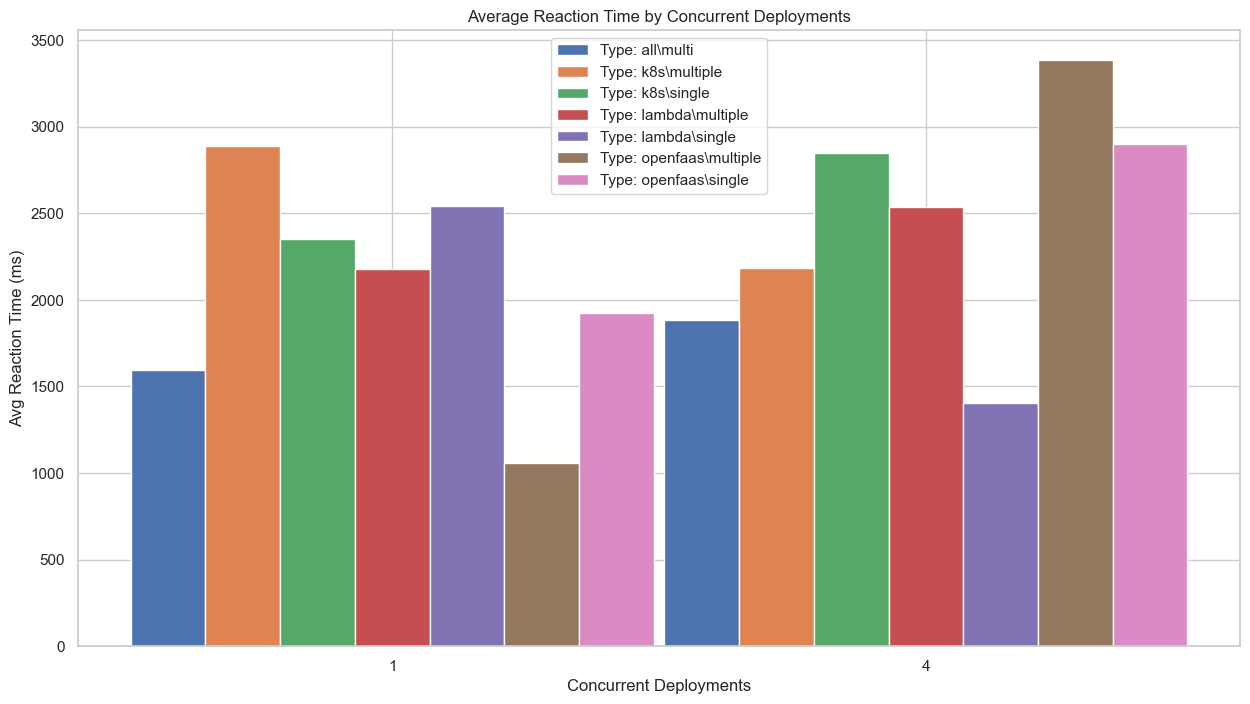

In [66]:
df_rt_grouped = df_reaction_time.groupby(['type', 'concurrent_deployments'])['reaction_time'].mean().reset_index()
unique_types = df_rt_grouped['type'].unique()
unique_concurrent_deployments = df_rt_grouped['concurrent_deployments'].unique()
bar_width = 0.14
plt.figure(figsize=(15, 8))

for i, type_value in enumerate(unique_types):
       df_rt_filtered_grouped = df_rt_grouped[df_rt_grouped['type'] == type_value]
       bar_positions = []
       for j, concurrent_deployments in enumerate(unique_concurrent_deployments):
              for index, entry in df_rt_filtered_grouped.iterrows():
                     if entry['concurrent_deployments'] == concurrent_deployments:
                            bar_positions.append(j + i * bar_width)
                            continue
       #bar_positions = [j + i * bar_width for j in range(len(unique_concurrent_deployments))]              
       plt.bar(bar_positions, df_rt_filtered_grouped['reaction_time'], width=bar_width, label=f'Type: {type_value}')

plt.xlabel('Concurrent Deployments')
plt.ylabel('Avg Reaction Time (ms)')
plt.title('Average Reaction Time by Concurrent Deployments')
plt.xticks([j + (len(unique_types) - 1) * bar_width / 2 for j in range(len(unique_concurrent_deployments))],
           unique_concurrent_deployments)
plt.legend()
plt.show()

In [67]:
df_rt_grouped

,type,concurrent_deployments,reaction_time
0,all\multi,1,1594.000000
1,all\multi,4,1884.333333
2,k8s\multiple,1,2890.000000
3,k8s\multiple,4,2183.333333
4,k8s\single,1,2351.666667
5,k8s\single,4,2848.333333
6,lambda\multiple,1,2177.333333
7,lambda\multiple,4,2537.000000
8,lambda\single,1,2539.666667
9,lambda\single,4,1406.000000


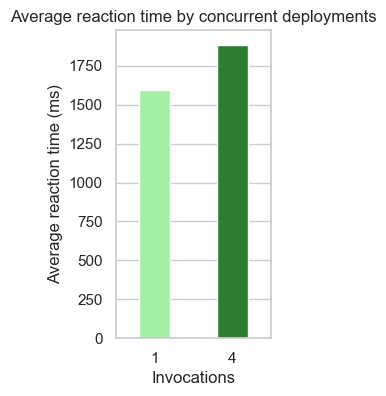

In [88]:
plt.figure(figsize=(2, 4))
sns.barplot(x='concurrent_deployments', y='reaction_time', hue='concurrent_deployments', data=df_rt_grouped[df_rt_grouped['type'] == 'all\multi'], legend=False, palette=['palegreen', 'forestgreen'], width=0.4)
plt.title('Average reaction time by concurrent deployments')
plt.xlabel('Invocations')
plt.ylabel('Average reaction time (ms)')
plt.show()